<a href="https://colab.research.google.com/github/greek-nlp/benchmark/blob/main/impostors_nlp_gr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Krikri

In [1]:
%%capture
!pip install torch transformers accelerate

In [2]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

# Set the model ID and the device
model_id = "ilsp/Llama-Krikri-8B-Instruct"
device = "cuda" # or "cpu" if you have a powerful CPU and limited VRAM

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_id)

# Load the model
# Note: Llama 3.1 models require you to accept their license on Hugging Face first.
# You may also need to log in via 'huggingface-cli login' in your terminal.
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.bfloat16, # Use bfloat16 for efficiency on supported GPUs
    device_map="auto"           # Automatically distribute the model across available devices
)
model.to(device)

# Prepare your instruction/prompt
prompt = "Ποια είναι η πρωτεύουσα της Ελλάδας;" # "What is the capital of Greece?"

# Apply the chat template for the Instruct model
messages = [
    {"role": "user", "content": prompt}
]
input_ids = tokenizer.apply_chat_template(
    messages,
    tokenize=True,
    add_generation_prompt=True,
    return_tensors="pt"
).to(device)

# Generate the response
outputs = model.generate(
    input_ids,
    max_new_tokens=256,
    do_sample=True,
    temperature=0.7,
    pad_token_id=tokenizer.eos_token_id
)

# Decode and print the result
response = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(response)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/19.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/752 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/955 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.91G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.57G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/184 [00:00<?, ?B/s]

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


system

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

user

Ποια είναι η πρωτεύουσα της Ελλάδας;assistant

Η πρωτεύουσα της Ελλάδας είναι η Αθήνα.


In [17]:
def prompt_krikri(model, prompt, system_prompt, temperature=0.3):
  messages = [
      {"role": "system", "content": system_prompt},
      {"role": "user", "content": prompt},
  ]

  input_ids = tokenizer.apply_chat_template(
      messages,
      tokenize=True,
      add_generation_prompt=True,
      return_tensors="pt"
  ).to(device)

  outputs = model.generate(
      input_ids,
      max_new_tokens=256,
      do_sample=True,
      temperature=temperature,
      pad_token_id=tokenizer.eos_token_id
  )
  #response = tokenizer.decode(outputs[0], skip_special_tokens=True)

  full_response = tokenizer.decode(outputs[0], skip_special_tokens=False)

  assistant_prefix = "<|start_header_id|>assistant<|end_header_id|>"
  response = full_response.split(assistant_prefix)[-1].strip()

  # Finally, remove the end-of-turn token if it appears
  response = response.replace("<|eot_id|>", "").strip()

  return response

# Data access

In [3]:
%%capture
!git clone https://github.com/greek-nlp/gen-a.git
!pip install zenodo-get
!pip install datasets
!pip install conll-df

import pandas as pd
import importlib

gr_data = pd.read_csv('gen-a/data.csv')
gena = importlib.import_module("gen-a.data_wrapper")

In [4]:
barzokas = gena.BarzokasDt(datasets=gr_data).get('train')
barzokas.drop_duplicates(inplace=True, subset=['text'])
barzokas_df = barzokas[barzokas.status=='parsable']
barzokas_df.sample()

Download github items in directory: /content/repo_56
Successfully downloaded data/corpora


,id,title,author,type,publishedYear,isbn,filename,postUrl,attachmentUrl,authorYearOfBirth,authorYearOfDeath,tokensCount,text,status,publisher
394,openBook161,Σιμονέτα,Κατερίνα Καζολέα,Θεατρικό έργο,2018,NaN,Σιμονέτα.pdf,https://www.openbook.gr/simoneta/,http://bit.ly/2CxQJtz,NaN,NaN,8115.0,ΚΑΤΕΡΙΝΑ ΚΑΖΟΛΕΑ Σ Ι Μ Ο Ν Ε Τ Α ...,parsable,openbook


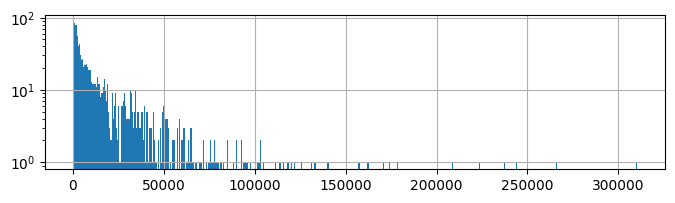

In [5]:
barzokas_df.tokensCount.hist(bins=500, figsize=(8,2), log=True);
barzokas_df = barzokas_df[barzokas_df.tokensCount>1000]

In [32]:
import random

def get_random_middle_excerpt(text, length=1000, offset_range=10000):
  """
  Returns an excerpt by choosing a random start point within
  a certain range around the absolute middle of the text.
  """
  text_length = len(text)

  # 1. Find the ideal middle start (if we were taking the fixed middle)
  middle_start_ideal = text_length // 2 - length // 2

  # 2. Define the range for the random starting point
  # The starting point will be between:
  #   max(0, middle_start_ideal - offset_range)
  # and
  #   min(text_length - length, middle_start_ideal + offset_range)

  # Ensure the start index is not negative and the excerpt fits in the text
  min_start = max(0, middle_start_ideal - offset_range // 2)
  max_start = min(text_length - length, middle_start_ideal + offset_range // 2)

  # Handle cases where the text is too short
  if min_start >= max_start:
      return text[:length] # Just return the first part or the whole text if shorter

  # 3. Pick a random starting index
  start_index = random.randint(min_start, max_start)

  # 4. Extract the excerpt
  return text[start_index : start_index + length]

# To get multiple diverse, yet middle-focused samples:
# sample1 = get_random_middle_excerpt(text)
# sample2 = get_random_middle_excerpt(text)

# Loop 10 times to create 10 new columns
for i in range(1, 11):
  barzokas_df[f'excerpt_{i}'] = barzokas_df.text.apply(get_random_middle_excerpt)

In [33]:
barzokas_df[['id', 'title', 'excerpt', 'author', 'type', 'publishedYear', 'tokensCount']].to_csv('barzokas_excerpt.csv', index=False)

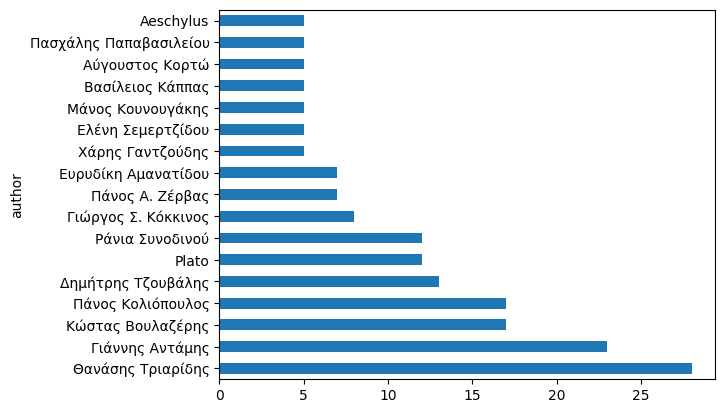

In [34]:
pop_authors = barzokas_df.author.value_counts()[:17].index.tolist()
barzokas_pop = barzokas_df[barzokas_df.author.isin(pop_authors)]
barzokas_pop.author.value_counts().plot.barh();

In [37]:
barzokas_pop.excerpt_1.apply(len).describe()

,excerpt_1
count,179.0
mean,1000.0
std,0.0
min,1000.0
25%,1000.0
50%,1000.0
75%,1000.0
max,1000.0


In [38]:
from tqdm.notebook import tqdm
instruct = "Given an excerpt from a Greek book, return the author it is from by picking from the following authors: " + ', '.join(pop_authors) +' Return only the name of the author, nothing else.'
for i in tqdm(range(1, 11)):
  barzokas_pop[f'krikri_{i}'] = [prompt_krikri(model, t, instruct) for t in tqdm(barzokas_pop[f'excerpt_{i}'].values)]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

/tmp/ipython-input-3536644831.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  barzokas_pop[f'krikri_{i}'] = [prompt_krikri(model, t, instruct) for t in tqdm(barzokas_pop[f'excerpt_{i}'].values)]


  0%|          | 0/179 [00:00<?, ?it/s]

/tmp/ipython-input-3536644831.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  barzokas_pop[f'krikri_{i}'] = [prompt_krikri(model, t, instruct) for t in tqdm(barzokas_pop[f'excerpt_{i}'].values)]


  0%|          | 0/179 [00:00<?, ?it/s]

/tmp/ipython-input-3536644831.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  barzokas_pop[f'krikri_{i}'] = [prompt_krikri(model, t, instruct) for t in tqdm(barzokas_pop[f'excerpt_{i}'].values)]


  0%|          | 0/179 [00:00<?, ?it/s]

/tmp/ipython-input-3536644831.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  barzokas_pop[f'krikri_{i}'] = [prompt_krikri(model, t, instruct) for t in tqdm(barzokas_pop[f'excerpt_{i}'].values)]


  0%|          | 0/179 [00:00<?, ?it/s]

/tmp/ipython-input-3536644831.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  barzokas_pop[f'krikri_{i}'] = [prompt_krikri(model, t, instruct) for t in tqdm(barzokas_pop[f'excerpt_{i}'].values)]


  0%|          | 0/179 [00:00<?, ?it/s]

/tmp/ipython-input-3536644831.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  barzokas_pop[f'krikri_{i}'] = [prompt_krikri(model, t, instruct) for t in tqdm(barzokas_pop[f'excerpt_{i}'].values)]


  0%|          | 0/179 [00:00<?, ?it/s]

/tmp/ipython-input-3536644831.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  barzokas_pop[f'krikri_{i}'] = [prompt_krikri(model, t, instruct) for t in tqdm(barzokas_pop[f'excerpt_{i}'].values)]


  0%|          | 0/179 [00:00<?, ?it/s]

/tmp/ipython-input-3536644831.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  barzokas_pop[f'krikri_{i}'] = [prompt_krikri(model, t, instruct) for t in tqdm(barzokas_pop[f'excerpt_{i}'].values)]


  0%|          | 0/179 [00:00<?, ?it/s]

/tmp/ipython-input-3536644831.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  barzokas_pop[f'krikri_{i}'] = [prompt_krikri(model, t, instruct) for t in tqdm(barzokas_pop[f'excerpt_{i}'].values)]


  0%|          | 0/179 [00:00<?, ?it/s]

/tmp/ipython-input-3536644831.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  barzokas_pop[f'krikri_{i}'] = [prompt_krikri(model, t, instruct) for t in tqdm(barzokas_pop[f'excerpt_{i}'].values)]


In [30]:
barzokas_pop['krikri'] = barzokas_pop.krikri.apply(lambda x: "Θανάσης Τριαρίδης" if "ανάση" in x else x)
barzokas_pop['krikri'] = barzokas_pop.krikri.apply(lambda x: "Plato" if "Plato" in x else x)
barzokas_pop['krikri'] = barzokas_pop.krikri.apply(lambda x: "Κολιόπουλος" if "Κολιόπουλος" in x else x)

/tmp/ipython-input-3389270823.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  barzokas_pop['krikri'] = barzokas_pop.krikri.apply(lambda x: "Θανάσης Τριαρίδης" if "ανάση" in x else x)
/tmp/ipython-input-3389270823.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  barzokas_pop['krikri'] = barzokas_pop.krikri.apply(lambda x: "Plato" if "Plato" in x else x)
/tmp/ipython-input-3389270823.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

In [51]:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
barzokas_pop_mini = barzokas_pop[:175]
p,r,f = [],[],[]
for i in range(1,11):
  p.append(precision_score(barzokas_pop_mini.author, barzokas_pop_mini[f'krikri_{i}'].str.strip(), labels=pop_authors, zero_division=0, average='macro'))
  r.append(recall_score(barzokas_pop_mini.author, barzokas_pop_mini[f'krikri_{i}'].str.strip(), labels=pop_authors, zero_division=0, average='macro'))
  f.append(f1_score(barzokas_pop_mini.author, barzokas_pop_mini[f'krikri_{i}'].str.strip(), labels=pop_authors, zero_division=0, average='macro'))

print(f'P: {pd.Series(p).mean():.3f} ({pd.Series(p).sem():.3f})')
print(f'R: {pd.Series(r).mean():.3f} ({pd.Series(r).sem():.3f})')
print(f'F: {pd.Series(f).mean():.3f} ({pd.Series(f).sem():.3f})')

#print(classification_report(barzokas_pop_mini.author, barzokas_pop_mini.krikri_8.str.strip(), zero_division=0, labels=pop_authors))

P: 0.466 (0.027)
R: 0.217 (0.009)
F: 0.223 (0.012)


In [44]:
barzokas_pop_mini.to_csv('barzokas_krikri.csv')

In [53]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

num_runs = 10
num_samples = 175
np.random.seed(42)

author_metrics = {
    author: {'P': [], 'R': [], 'F': []} for author in pop_authors
}

for i in range(1, 11):
    pred_col = f'krikri_{i}'
    y_true = barzokas_pop_mini['author']
    y_pred = barzokas_pop_mini[pred_col].str.strip() # Ensure stripping is applied here

    # Get the classification report dictionary for the current run
    report = classification_report(
        y_true,
        y_pred,
        labels=pop_authors,
        zero_division=0,
        output_dict=True
    )

    # Store P, R, F scores for each individual author
    for author in pop_authors:
        if author in report:
            author_metrics[author]['P'].append(report[author]['precision'])
            author_metrics[author]['R'].append(report[author]['recall'])
            author_metrics[author]['F'].append(report[author]['f1-score'])

# 3. Calculate Mean and SEM for each author's metrics
results = {}
for author, metrics in author_metrics.items():
    results[author] = {
        'P_mean': np.mean(metrics['P']),
        'P_sem': pd.Series(metrics['P']).sem(),
        'R_mean': np.mean(metrics['R']),
        'R_sem': pd.Series(metrics['R']).sem(),
        'F_mean': np.mean(metrics['F']),
        'F_sem': pd.Series(metrics['F']).sem()
    }

# 4. Report the results
print("--- Mean (SEM) Performance Per Author Across 10 Runs ---")
for author in pop_authors:
    res = results[author]
    print(f"\nAuthor: {author}")
    print(f"  P: {res['P_mean']:.3f} ({res['P_sem']:.3f})")
    print(f"  R: {res['R_mean']:.3f} ({res['R_sem']:.3f})")
    print(f"  F1: {res['F_mean']:.3f} ({res['F_sem']:.3f})")

# Optionally, you can also format the final macro-average results from the initial prompt:
p_macro = [np.mean(author_metrics[a]['P']) for a in pop_authors]
r_macro = [np.mean(author_metrics[a]['R']) for a in pop_authors]
f_macro = [np.mean(author_metrics[a]['F']) for a in pop_authors]

macro_p_mean = np.mean(p_macro)
macro_r_mean = np.mean(r_macro)
macro_f_mean = np.mean(f_macro)

# Recalculating SEM for the macro scores based on the 10 macro scores (as in your original code)
p_sem = pd.Series([np.mean(author_metrics[a]['P']) for a in pop_authors]).sem()
r_sem = pd.Series([np.mean(author_metrics[a]['R']) for a in pop_authors]).sem()
f_sem = pd.Series([np.mean(author_metrics[a]['F']) for a in pop_authors]).sem()

print("\n--- Overall Macro-Averages (10-Run Mean) ---")
print(f"P: {macro_p_mean:.3f} ({p_sem:.3f})")
print(f"R: {macro_r_mean:.3f} ({r_sem:.3f})")
print(f"F: {macro_f_mean:.3f} ({f_sem:.3f})")

--- Mean (SEM) Performance Per Author Across 10 Runs ---

Author: Θανάσης Τριαρίδης
  P: 0.967 (0.033)
  R: 0.075 (0.012)
  F1: 0.137 (0.021)

Author: Γιάννης Αντάμης
  P: 0.200 (0.133)
  R: 0.013 (0.009)
  F1: 0.024 (0.017)

Author: Πάνος Κολιόπουλος
  P: 0.000 (0.000)
  R: 0.000 (0.000)
  F1: 0.000 (0.000)

Author: Κώστας Βουλαζέρης
  P: 0.900 (0.100)
  R: 0.153 (0.028)
  F1: 0.256 (0.043)

Author: Δημήτρης Τζουβάλης
  P: 1.000 (0.000)
  R: 0.277 (0.033)
  F1: 0.424 (0.043)

Author: Ράνια Συνοδινού
  P: 0.000 (0.000)
  R: 0.000 (0.000)
  F1: 0.000 (0.000)

Author: Plato
  P: 0.071 (0.001)
  R: 1.000 (0.000)
  F1: 0.132 (0.001)

Author: Γιώργος Σ. Κόκκινος
  P: 0.967 (0.033)
  R: 0.400 (0.031)
  F1: 0.561 (0.035)

Author: Πάνος Α. Ζέρβας
  P: 0.200 (0.133)
  R: 0.029 (0.019)
  F1: 0.050 (0.033)

Author: Ευρυδίκη Αμανατίδου
  P: 0.575 (0.158)
  R: 0.143 (0.048)
  F1: 0.218 (0.067)

Author: Μάνος Κουνουγάκης
  P: 1.000 (0.000)
  R: 0.460 (0.067)
  F1: 0.605 (0.061)

Author: Ελένη Σεμερτ

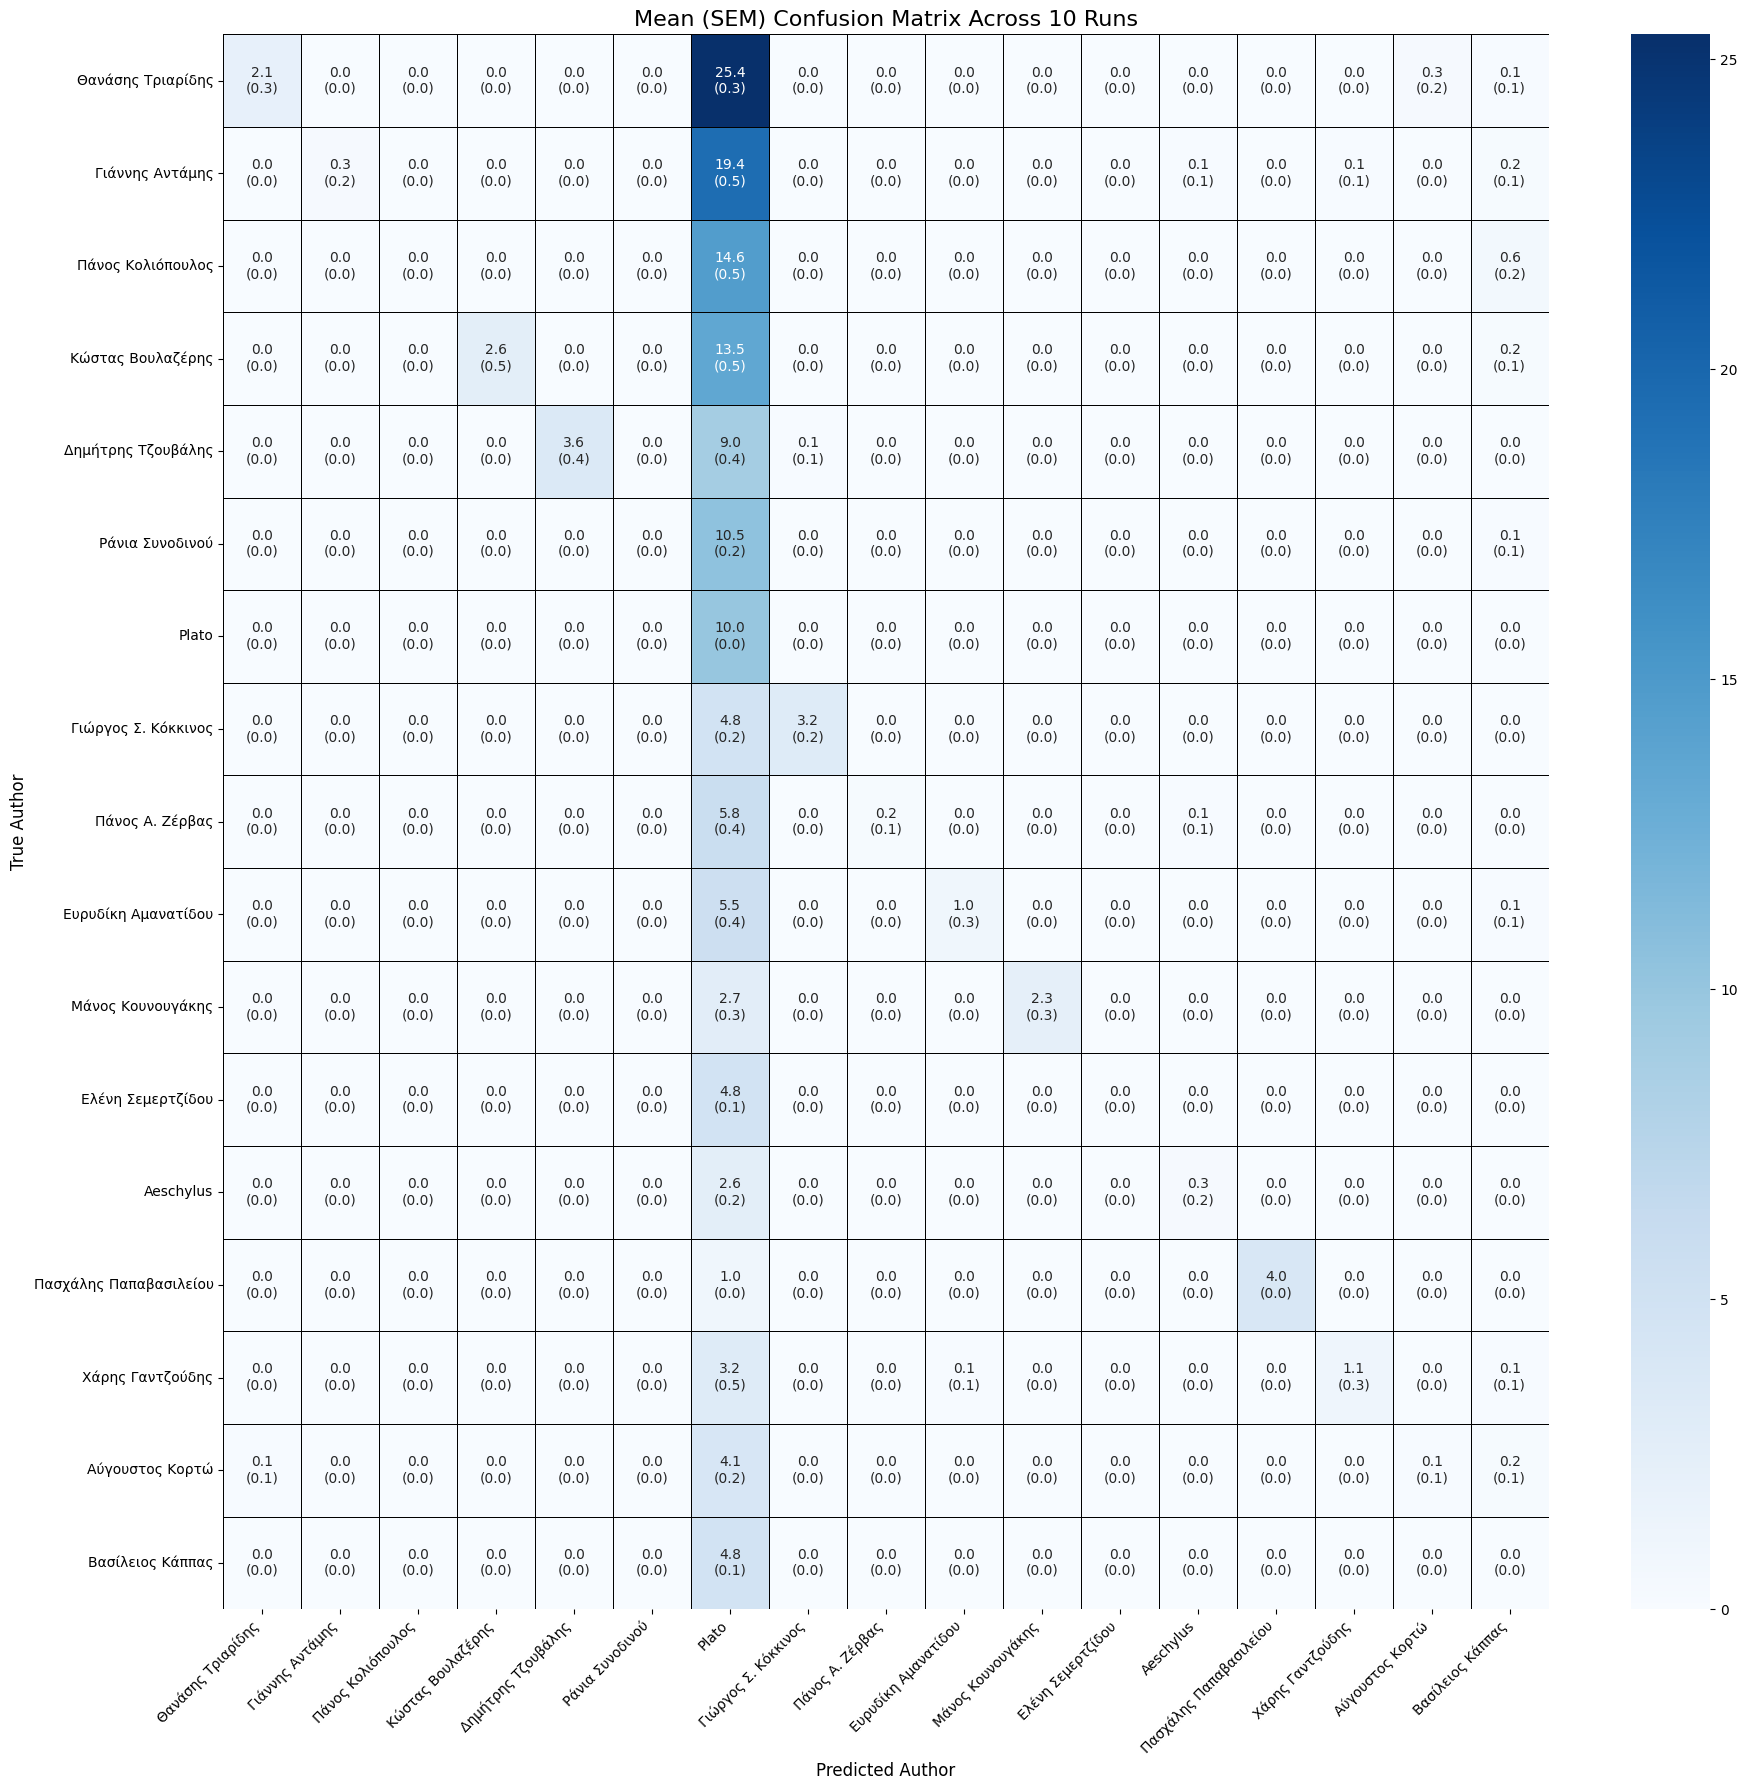

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

# Assuming pop_authors is defined and barzokas_pop_mini has the 'author' and 'krikri_i' columns
# Also assuming you have run the code to populate `all_cm_arrays` from the previous response

# --- Re-run the confusion matrix calculation for completeness ---
# 1. Initialize a 3D NumPy array to store all 10 confusion matrices
num_authors = len(pop_authors)
all_cm_arrays = np.zeros((10, num_authors, num_authors), dtype=int)

# 2. Modify the loop to collect the confusion matrix for each run
for i in range(1, 11):
    pred_col = f'krikri_{i}'
    y_true = barzokas_pop_mini['author']
    y_pred = barzokas_pop_mini[pred_col].str.strip()

    # Calculate the confusion matrix for the current run
    cm_i = confusion_matrix(y_true, y_pred, labels=pop_authors)

    # Store the 2D matrix into the 3D array
    all_cm_arrays[i-1] = cm_i

# 3. Calculate Mean and Standard Error of the Mean (SEM)
mean_cm = np.mean(all_cm_arrays, axis=0)
std_cm = np.std(all_cm_arrays, axis=0, ddof=1) # ddof=1 for sample std dev
sem_cm = std_cm / np.sqrt(10) # N = 10 runs
# -------------------------------------------------------------------


# 4. Prepare annotations for the heatmap
# We'll create a new array of strings "Mean (SEM)"
annotations = np.empty_like(mean_cm, dtype=object)
for i in range(num_authors):
    for j in range(num_authors):
        annotations[i, j] = f"{mean_cm[i, j]:.1f}\n({sem_cm[i, j]:.1f})" # Newline for readability


# 5. Create the Heatmap Visualization
plt.figure(figsize=(num_authors + 2, num_authors + 1)) # Adjust size dynamically

sns.heatmap(
    mean_cm,                # The data to color the cells (mean counts)
    annot=annotations,      # The custom annotations (Mean (SEM))
    fmt='s',                # Format as string because annotations are strings
    cmap='Blues',           # Color map
    cbar=True,              # Show color bar
    linewidths=.5,          # Lines between cells
    linecolor='black',      # Color of lines
    xticklabels=pop_authors,
    yticklabels=pop_authors
)

plt.title('Mean (SEM) Confusion Matrix Across 10 Runs', fontsize=16)
plt.xlabel('Predicted Author', fontsize=12)
plt.ylabel('True Author', fontsize=12)
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability
plt.yticks(rotation=0)
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

https://gemini.google.com/share/62c59af9933f